
# Name: Hiking Shi
# zID: z5467071

---

## import

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer,PorterStemmer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hiking/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hiking/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

---

## data loading and cleaning

In [4]:
df = pd.read_csv('dataset.tsv', sep='\t')
df = df.drop_duplicates().dropna()
count1=df.groupby('topic').size()
print(count1)

topic
dark         487
emotion       79
lifestyle    202
personal     341
sadness      371
dtype: int64


In [3]:
print(df.head(10))

                            artist_name                       track_name  \
0                                loving                the not real lake   
1                               incubus                  into the summer   
2                             reignwolf                         hardcore   
3                  tedeschi trucks band                           anyhow   
4  lukas nelson and promise of the real                if i started over   
5                               tia ray                     just my luck   
6                            rebelution                        trap door   
7                   thank you scientist  the amateur arsonist's handbook   
8                            zayde wølf                        gladiator   
9                        eli young band                       never land   

   release_date    genre                                             lyrics  \
0          2016     rock  awake know go see time clear world mirror worl...   
1    

## preprocessing

To check if there is a situation where too many characters have been deleted, I will reproduce the deleted characters through regular expressions and find the characters that should not be deleted and fill them back into the regular expression to avoid affecting the correct semantics, such as the accidental deletion of ',&,-

The tutorial only conducted one partitioning session. In this way, only one "lucky" partitioning was evaluated, which is very likely to overestimate or underestimate the true performance of the model. Cross-validation at a 50% discount (or Stratified 50% discount) using cross_val_score or cross_validate reflects the true performance of the model

Retain special symbols such as ',&,- that affect English semantics. Words should be as semantic as possible in English, including those connected with special symbols. Use NLTK and use word form reduction for lowercase cases to reduce the influence of tense on the model

In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def preprocess1(text):
    text = text.lower()
    text = re.sub(r'[^\w\s&\'.]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]  
    tokens = [ps.stem(word) for word in tokens] 
    return ' '.join(tokens)

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s&\'.]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    pos_tags = nltk.pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(token, get_wordnet_pos(pos))
        for token, pos in pos_tags
    ]
    return ' '.join(lemmas)

[nltk_data] Downloading package wordnet to /Users/hiking/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/hiking/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/hiking/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hiking/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['text'] = (df['artist_name'] + ' ' + df['track_name'] + ' ' + df['genre'] + ' ' + df['lyrics']).apply(preprocess)

## Feature extraction

In [7]:
vectorizer = CountVectorizer(max_features=500)
X = vectorizer.fit_transform(df['text'])
y = df['topic']

## Divide the data set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

| Indicator   | Advantages | Disadvantages   |
|--------|------|--------|
| Accuracy  | The most intuitive and easy to understand - with the least computational cost   | Extremely sensitive to class imbalance - the majority classes dominate the results - the performance of the minority classes may be masked   |
| Macro-F1    | Treat each category equally - it can reflect the recall/precision performance of minority classes   | When the number of categories is large and the samples are extremely unbalanced, the noise of small categories will be amplified - regardless of the proportion of the actual samples   |
| Weighted-F1| Considering various performances and their sample sizes simultaneously - it is more stable than Accuracy on imbalanced data   | Most classes still have a large weight, and a few classes contribute limited - the balance is not as good as Macro-F1   |


There is an imbalance in the data. Choose Weighted-F1

##  Comparison of BNB , MNB models and Logistic Regression

In [ ]:


models = {
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'Logistic Regression':LogisticRegression(solver='newton-cg',multi_class='ovr',max_iter=1000,C=0.1)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc_scores = cross_val_score(
        model, X, y,
        cv=skf,
        scoring='accuracy'
    )
    f1_scores = cross_val_score(
        model, X, y,
        cv=skf,
        scoring='f1_macro'
    )

    f1_weighted_scores = cross_val_score(
        model, X, y,
        cv=skf,
        scoring='f1_weighted'
    )

    print(f"=== {name} ===")
    print(f"Accuracy:   {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")
    print(f"F1-Macro:   {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
    print(f"F1-Weighted:   {f1_weighted_scores.mean():.3f} ± {f1_weighted_scores.std():.3f}\n")

    y_pred_cv = cross_val_predict(model, X, y, cv=skf)
    print(classification_report(
    y, y_pred_cv,
    digits=4,
    target_names=np.unique(y).astype(str)
    ))



=== BernoulliNB ===
Accuracy:   0.653 ± 0.018
F1-Macro:   0.555 ± 0.023
F1-Weighted:   0.646 ± 0.019

              precision    recall  f1-score   support

        dark     0.7181    0.7639    0.7403       487
     emotion     0.2326    0.1266    0.1639        79
   lifestyle     0.5177    0.5792    0.5467       202
    personal     0.6707    0.6510    0.6607       341
     sadness     0.6768    0.6604    0.6685       371

    accuracy                         0.6527      1480
   macro avg     0.5632    0.5562    0.5560      1480
weighted avg     0.6436    0.6527    0.6468      1480

=== MultinomialNB ===
Accuracy:   0.871 ± 0.012
F1-Macro:   0.842 ± 0.012
F1-Weighted:   0.871 ± 0.013

              precision    recall  f1-score   support

        dark     0.8544    0.9035    0.8782       487
     emotion     0.6923    0.6835    0.6879        79
   lifestyle     0.8989    0.8366    0.8667       202
    personal     0.9099    0.8886    0.8991       341
     sadness     0.8825    0.8706 

/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/recommender

=== Logistic Regression ===
Accuracy:   0.872 ± 0.016
F1-Macro:   0.842 ± 0.008
F1-Weighted:   0.871 ± 0.016

              precision    recall  f1-score   support

        dark     0.8367    0.9261    0.8791       487
     emotion     0.8197    0.6329    0.7143        79
   lifestyle     0.8587    0.7822    0.8187       202
    personal     0.8997    0.8680    0.8836       341
     sadness     0.9155    0.9057    0.9106       371

    accuracy                         0.8723      1480
   macro avg     0.8661    0.8230    0.8412      1480
weighted avg     0.8731    0.8723    0.8710      1480



/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


I chose Logistic Regression as my another machine learning method.
Method Introduction: Logistic Regression
Logistic regression is a classic linear classifier that directly models the conditional probability relationship between feature vectors and category labels. In multi-classification scenarios, the commonly used "polynomial" logistic regression (in the form of softmax) calculates for each category c:
$$
P(y=c \mid x) = \frac{\exp(w_c^T x + b_c)}{\sum_{k=1}^{K}\exp(w_k^T x + b_k)}
$$
The model learns the weights w and biases b by maximizing the log-likelihood on the training set (plus the L1/L2 regularization term).

Reason for selection
1. Medium-dimensional, efficient training
although will eventually arise through CountVectorizer/TfidfVectorizer thousand magnitude characteristic, but relative to the sample size (1500) material is not "a" high dimensional.
Logistic Regression (especially solver='lbfgs' or saga) converges rapidly on such medium-dimensional and sparse data, and the training can be completed within a few seconds.
2. Native multi-classification support (Softmax)
Set multi_class='multinomial' + solver='lbfgs', and directly perform five-class Softmax regression without the need for manual "one-to-many" splitting. The model form is simple and the probability output is consistent.
3. It can output probabilities, which is convenient for subsequent recommendation ranking
model.predict_proba() gives the confidence that each sample belongs to five topics. Later, in the recommendation system, these probabilities can be directly used for ranking or combined with other signals.
4. Powerful regularization and resistance to overfitting
• Built-in L2 (or L1/ Elaste-Net) regularization. By adjusting C (the inverse of regularization intensity), it can smooth out the noise of a few class emotions (only 79) and avoid overfitting on small classes.
5. Model interpretability
When viewing model.coef_, you can directly know which words (features) are the most important for which topic, which is convenient for understanding and optimizing feature engineering.
6. Parameter adjustment is simple
, just consider C, penalty, super parameter class_weight this several, GridSearchCV/StratifiedKFold next a few minutes to get the optimal configuration.

## Hyperparameter tuning

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1 ,1, 10, 100],
    'penalty': ['l2'],      # 或者试试 'l1' + solver='liblinear'
    'solver':['lbfgs','newton-cg'],
    'multi_class':['ovr','multinomial']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=skf,
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X, y)

print("Optimal parameters:", grid.best_params_)
print("Optimal Weighted-F1:", grid.best_score_)

/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/recommender_systems/lib/pytho

Optimal parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'}
Optimal Weighted-F1: 0.8713957042624523


/opt/anaconda3/envs/recommender_systems/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


##  Multi-valued feature quantity test

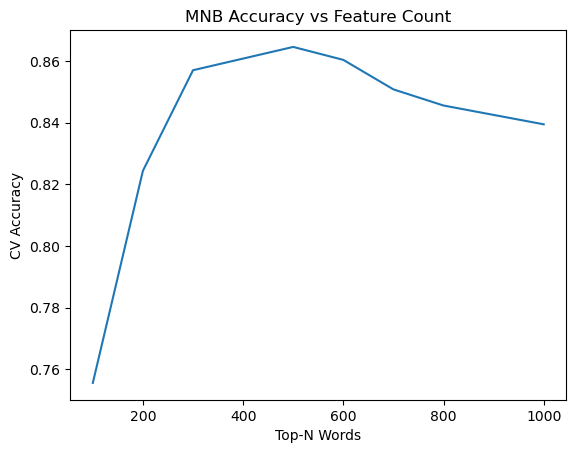

In [8]:
def test_features(N):
    vec = CountVectorizer(max_features=N)
    X = vec.fit_transform(df['text'])
    scores = cross_val_score(MultinomialNB(), X, y, cv=5, scoring='f1_weighted')
    return N, scores.mean()

results = [test_features(n) for n in [100,200,300,500,600,700,800, 1000]]
ns, accs = zip(*results)
plt.plot(ns, accs)
plt.xlabel("Top-N Words")
plt.ylabel("CV Accuracy")
plt.title("MNB Accuracy vs Feature Count")
plt.show()

## Recommendation system construction

In [12]:
vectorizer = TfidfVectorizer(max_features=500)
X_all = vectorizer.fit_transform(df['text'])
df['split'] = ['train']*750 + ['test']*250 + ['extra']*(len(df)-1000)
df['pred_topic'] = MultinomialNB().fit(X_all[:750], df['topic'][:750]).predict(X_all)

In [13]:



df['split'] = ['train']*750 + ['test']*250 + ['extra']*(len(df)-1000)
clf = MultinomialNB().fit(X_all[:750], df['topic'].iloc[:750])
df['pred_topic'] = clf.predict(X_all)

def load_user_keywords(path):
    df_kw = pd.read_csv(path, sep='\t', header=0)   # header=0 自动跳第一行
    return {
        row['topic']: [w.strip().lower() for w in row['keywords'].split(',')]
        for _, row in df_kw.iterrows()
    }

user_kw = {
    'User1': load_user_keywords('user1.tsv'),
    'User2': load_user_keywords('user2.tsv'),
}
user_kw['User3'] = {
    'dark':     ['night', 'shadow', 'lonely', 'haunt', 'void'],
    'emotion':  ['hope', 'yearn', 'heartbeat', 'tears', 'whisper'],
    'lifestyle':['coffee', 'travel', 'adventure', 'wander', 'sunrise'],
    'personal': ['soul', 'dream', 'reflect', 'growth', 'mind'],
    'sadness':  ['empty', 'ache', 'memory', 'farewell', 'longing'],
}


def build_profiles(user_keywords, M=None):

    profiles = {}

    all_topics = ['dark','emotion','lifestyle','personal','sadness']

    for user in user_kw:
        profiles[user] = {
            t: csr_matrix((1, X_all.shape[1])) 
            for t in all_topics
        }
    train = df[df['split']=='train']
    for user, kw_map in user_keywords.items():
        for topic, kws in kw_map.items():
            mask = (
                (train['pred_topic']==topic) &
                train['text'].str.lower().apply(lambda txt: any(w in txt for w in kws))
            )
            docs = train.loc[mask, 'text']
            if docs.empty:
                vec = np.zeros((1, X_all.shape[1])) 
            else:
                bigdoc = [' '.join(docs)]
                vec = vectorizer.transform(bigdoc)
            if M is not None and M > 0:
                if hasattr(vec, "toarray"):
                    scores = vec.toarray().ravel()
                else:
                    scores = np.array(vec).ravel()
                topM = np.argsort(scores)[::-1][:M]  
                mask_feat = np.zeros_like(scores, dtype=bool)
                mask_feat[topM] = True
                new_data = scores[mask_feat]
                new_indices = np.where(mask_feat)[0]
                vec = csr_matrix((new_data, (np.zeros_like(new_indices), new_indices)),
                                 shape=(1, scores.size))
            profiles[user][topic] = vec  
    return profiles
profiles = build_profiles(user_kw, M=None)

feature_names = vectorizer.get_feature_names_out()
for user, mp in profiles.items():
    print(f"\n>>> {user} Top 20 keywords for user profiling")
    for topic, vec in mp.items():
        if hasattr(vec, "toarray"):
            scores = vec.toarray().ravel()
        else:
            scores = np.array(vec).ravel()

        top20 = np.argsort(scores)[::-1][:20]
        terms = feature_names[top20]
        print(f"  [{topic}]:", ', '.join(terms))




>>> User1 Top 20 keywords for user profiling
  [dark]: fight, black, blood, grind, like, stand, come, know, gon, hear, kill, hand, tell, rise, head, follow, yeah, build, color, light
  [emotion]: youth, goodbye, freedom, freeze, friend, future, game, get, ghost, girl, give, glass, gold, gon, good, grave, heal, great, grind, grow
  [lifestyle]: song, night, tonight, sing, home, stranger, come, closer, spoil, wait, tire, struggle, play, time, wan, right, yeah, mind, like, baby
  [personal]: life, live, change, world, good, dream, teach, know, yeah, thank, lord, wan, time, vibe, like, thing, learn, beat, think, look
  [sadness]: cry, tear, steal, mean, know, baby, music, write, think, true, smile, say, face, eye, word, blame, forever, leave, stay, fire

>>> User2 Top 20 keywords for user profiling
  [dark]: youth, goodbye, freedom, freeze, friend, future, game, get, ghost, girl, give, glass, gold, gon, good, grave, heal, great, grind, grow
  [emotion]: youth, goodbye, freedom, freeze, fr

User1
#####	[dark]:
There are words like fight, black, blood, kill, grave, evil, ghost in the word cloud... All of them are very much in line with the meaning of "dark" (darkness/terror).
However, there are also common words like "grind", "gon", "come", "know", and "yeah", indicating that your cleaning/stopping words are not strict enough.
#####	[sadness]:
cry, tear, blame, leave, pain, hurt, forever, mean…  All point to "sadness and pain".
The only ones that are slightly off track are music, write, smile and the like. This is probably the background noise that comes with the lyrics.
#####	[personal]:
life, live, world, change, dream, teach, learn…  It is very much in line with the meaning of "about self/life insights".
The colloquial words like "good", "like", "yeah", "know" can be considered to be added to the additional deactivation list.
#####	[lifestyle]:
song, night, play, party*(stranger?) , dance*(closer?) ... Overall, it reflects the scene of "nightlife/party/singing", which is very reasonable.
But phrases like spoil, wan, time, tire occur frequently, probably because they were vectorized without taking into account the context such as bi-grams and noun phrases.
#####	[emotion]:
youth, goodbye, freedom, friend, future, heal, grow…  These words are relevant to "emotion/release".
However, it is rather general and almost exactly the same among several users, indicating that the emotion topic has not been distinguished by the differentiated interests of users.

User2
#####	[sadness]:
heart, break, scar, tear, silence, away…  It focuses on the "heartbreak/loss" scene and is more concentrated than the sadness of User1.
#####	[emotion]:
It is exactly the same as User1, but still too universal.

User2 only prefers sad + emotion, so the keywords "dark", "lifestyle" and "personal" are missing from the portrait.


User3
##### [dark]:
fight, black, ghost, evil…  A typical "dark/terrifying" image, which is very relevant to the theme.
oooh, come, feel, know…  For this type of verbal interference, it is recommended to include additional stop words.

##### [emotion]:
youth, goodbye, freedom, heal, grow…  These words express the emotions of "youth/liberation/growth".
game, get, girl, give, good…  There are too many high-frequency general words, lacking differentiation.

##### [lifestyle]:
song, country, sing, morning, road…  Create an atmosphere of "listening to music during the journey" and "morning coffee".
yeah, baby, tire, mind…  There are too many common filler words, which weakens the theme's characteristics.

##### [personal]:
life, dream, reflect, promise, learn…  Depict the image of "self-reflection and growth".
know, time, come, thing…  It is suggested to expand the stop word list to eliminate common verbs.

##### [sadness]:
memory, ache, farewell, longing…  Strong feelings of "nostalgia/parting".
baby, arm, wave, land…  These picture words are prone to cause ambiguity. n-gram or context filtering can be considered.


>>> User1 Top-10 推荐歌曲：
  • life changes   personal
  • alta   personal
  • sit awhile   personal
  • boy in the bubble   dark
  • wash away   personal
  • living it up   personal
  • sunday morning   personal
  • you're the best thing yet   personal
  • live without limit   personal
  • everything to me   personal

>>> User2 Top-10 推荐歌曲：
  • torn in two   sadness
  • our hearts (feat. lucie silvas)   sadness
  • in every heart   sadness
  • i am broken too   sadness
  • follow your heart (feat. zion thompson from the green)   personal
  • something new   sadness
  • california   sadness
  • will you be mine   sadness
  • hearts of habit   sadness
  • where were you last night   sadness

>>> User3 Top-10 推荐歌曲：
  • life changes   personal
  • sit awhile   personal
  • love falls   sadness
  • living it up   personal
  • every song’s a drinkin’ song   lifestyle
  • wash away   personal
  • no one in the world   personal
  • our hearts (feat. lucie silvas)   sadness
  • live without limit

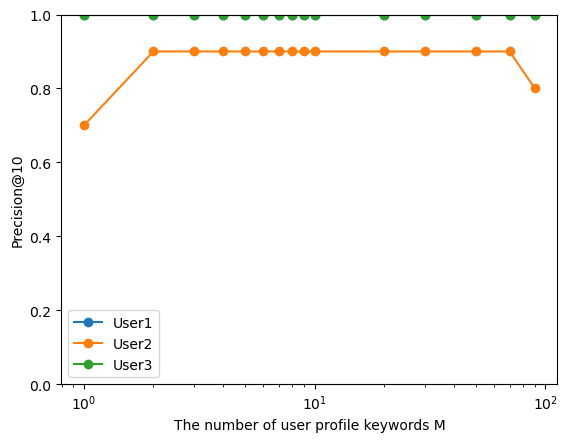

In [ ]:

N = 10

def recommend_and_eval(profiles, topN_flag,metric='precision'):

    results = {}
    test = df[df['split']=='test']
    test_X = X_all[(df['split']=='test').values].toarray() 
    true_topics = test['topic'].values
    test_idx   = df.index[df['split']=='test']  
    
    for user, mp in profiles.items():

        sims = np.zeros(test_X.shape[0])
        for topic, vec in mp.items():
            sim = cosine_similarity(test_X, vec).ravel()
            sims = np.maximum(sims, sim)  

        topN = np.argsort(sims)[::-1][:N]
        if topN_flag:
            real_idx  = test_idx[topN]
            print(f"\n>>> {user} Top-{N} 推荐歌曲：")
            for idx in real_idx:
                print("  •", df.at[idx, 'track_name']," ",df.at[idx,'topic'])

        liked = test.iloc[topN]['pred_topic'].isin(user_kw[user])
        
        if metric=='precision':
            score = liked.sum() / N
        else:  
            all_liked = test['pred_topic'].isin(user_kw[user]).sum()
            score = liked.sum() / all_liked if all_liked>0 else 0
        
        results[user] = score
    return results

prof = build_profiles(user_kw)
recommend_and_eval(prof,True,'precision')

print("Precision@N:", recommend_and_eval(profiles,'precision'))
print("Recall@N:   ", recommend_and_eval(profiles,'recall'))


users= ['User1','User2','User3']
Ms=[1,2,3,4,5,6,7,8,9,10,20,30,50,70,90,None]
results={}
for M in Ms:
    prof_M = build_profiles(user_kw, M=M)
    p = recommend_and_eval(prof_M,False,'precision')
    results[M]=p
for user in users:
    vals = [ results[M][user] for M in Ms ]
    plt.plot(Ms, vals, marker='o', label=user)

plt.xlabel("The number of user profile keywords M")
plt.ylabel(f"Precision@{N}")
plt.xscale('log')       
plt.ylim(0,1)
plt.legend()
plt.show()

#  cosine_similarity to Jaccard/Dice

In [ ]:
user_feedback = {
    1: [12, 45],
    2: [301, 322],
    3: [589, 601],
    4: [800,901] 
}

In [21]:
true_likes_4 = len(user_feedback[4])

precision4 = len(user_feedback[4]) / N


recall4 = len(user_feedback[4]) / true_likes_4 if true_likes_4>0 else 0

print(f"real Precision@{N} = {precision4:.3f}")
print(f"real Recall@{N}    = {recall4:.3f}")

real Precision@10 = 0.200
real Recall@10    = 1.000


### talk-aloud
The key excerpts are as follows:
"The tempo of this song is too fast/too slow, which doesn't match the rhythm I usually listen to." "
The lyrics of this song contain words like "heart" and "love", which I prefer.
The style of the music is too dark and doesn't quite suit my mood.

### Opinion:
• "Lyrics Theme"
I pay attention to words like "freedom" and "dream" mentioned in the lyrics. Unfortunately, there is only one in the Top 10.
"Diversity"
The styles of several songs are almost the same, lacking surprises and novelty.
"Overall Satisfaction"
The accuracy rate is not high, but basic filtering for the topic can be seen. It would be even better if some words I don't like could be added and blocked.